### Instructions:
1. Use the comments provided to help you.
2. Write code only in the sections indicated by our comments. You can add training hyper-parameters of your choice in the training cells
3. The dataset and trained model folders should be **one level above** your notebook - that is, "../Datasets", "../trained_models" etc.  
   Suggested directory structure:  
   Root Folder/  
     - Datasets/  
     - Models/  
     - Src/  
       - CW2.ipynb  

In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
import cv2
import os
import torchvision

# Own packages
import matplotlib.pyplot as plt

from torchvision import transforms, utils
import torch.nn.functional as F


## Question 1: Filtering in 1D and 2D


### Part 1a) Implement a filter to remove low frequencies from the audio fileaudio.npy.  Plot the input and outputof your filter as line graphs. **(5 points)**
---
Complete this question by implementing the function `highpass_filter_audio` below, and plotting the output. Reminder: Your implementation of highpass_filter_audioshould only use numpy. You may use other libraries to display your results.

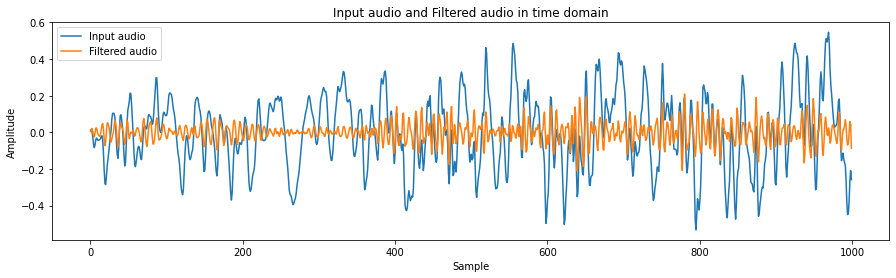

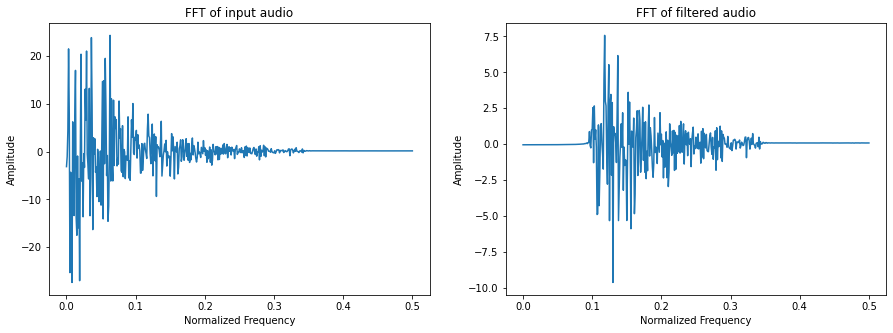

In [2]:
# PATH
input_audio_filename = "../Datasets/Filtering/audio.npy"

# LOAD input_audio FROM input_audio_filename
input_audio = np.load(input_audio_filename)

# Highpass filter function
def highpass_filter_audio(audio):
    # IMPLEMENT THIS FUNCTION
    # parameters
    cut_off_freq = 0.1
    numSample = 255

    # desing a finite impulse response low-pass filter.
    FIR_filter = np.sinc(2 * cut_off_freq * (np.arange(numSample) - (numSample - 1) / 2))
    window = np.hanning(numSample)
    FIR_filter *= window
    FIR_filter = FIR_filter / np.sum(FIR_filter)

    # desing a finite impulse response  high-pass filter
    FIR_filter *= -1
    FIR_filter[int((numSample - 1) / 2)] += 1
    
    # Convolution
    filtered_audio = np.convolve(audio, FIR_filter, 'same')

    return filtered_audio

# Calling the function
filtered_audio = highpass_filter_audio(input_audio)

# PLOT input_audio AND filtered_audio

# Plot for time domain 
plt.figure(figsize=(15,4))
plt.plot(input_audio,)
plt.plot(filtered_audio)
plt.title("Input audio and Filtered audio in time domain")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.legend(("Input audio", "Filtered audio"))

# Plot for fourier domain
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

# Input audio
fft_freq = np.fft.rfftfreq(len(input_audio))
fft_val = np.fft.rfft(input_audio)
ax1.plot(fft_freq, np.real(fft_val))
ax1.set_title("FFT of input audio")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Normalized Frequency")

# Filtered audio
fft_freq = np.fft.rfftfreq(len(filtered_audio))
fft_val = np.fft.rfft(filtered_audio)
ax2.plot(fft_freq, np.real(fft_val))
ax2.set_title("FFT of filtered audio")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Normalized Frequency")

plt.show()

The filtered audio has no frequency components in the 0 to 0.1 at the frequency domain. And the filtered audio is also scaled-down, as there is no gain in the system.

### Part 1b) Implement a filter to find vertical edges in an image.  We provide a sample fileimage.pngfor testing. Apply your filter to this image and display the input and output of your filter. **(10 points)**
---
Implement the function `detect_vertical_edges` below. This should apply a filter to detect vertical edges in the supplied input image. That is, your implementation should output a grayscale image of the same width and height as the input, with high values where vertical edges are present in the input image and low values elsewhere. Test your code on the supplied image.png. Display the input image and your output to demonstrate your implementation works correctly. Reminder: Your implementation of detect_vertical_edges should only use numpy. You may use other libraries to display your results.

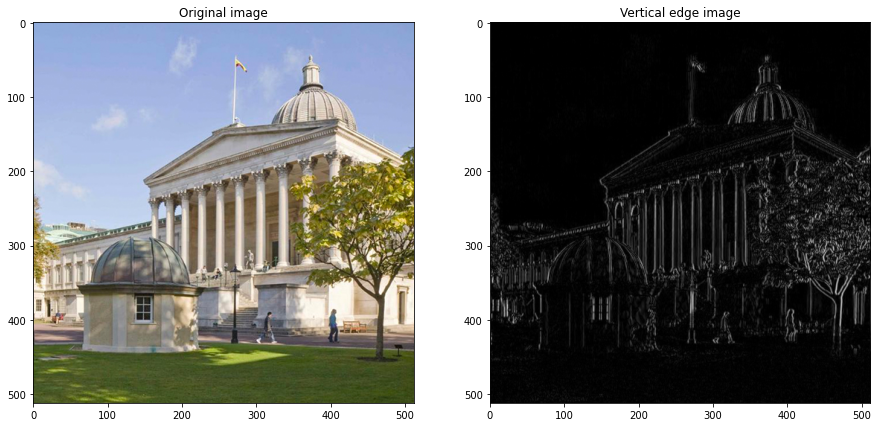

In [3]:
# PATH
input_image_filename = "../Datasets/Filtering/image.png"

# LOAD input_image FROM input_image_filename
input_image = cv2.imread(input_image_filename)
# Covert to RGB
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
# Normalize the input image
input_image = cv2.normalize(input_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Vertical edges detection
def detect_vertical_edges(image):
    # IMPLEMENT THIS FUNCTION
    # Dimension
    width, height = image.shape[0:2]

    filtered_image = np.zeros((width, height))
    # Filter 
    vertical_edge_filter = np.array([[-1, 0, 1],
                                     [-2, 0, 2],
                                     [-1, 0, 1]], np.float32)
    # Padding
    padded_image = np.zeros((width + 2, height + 2))
    padded_image[1:-1, 1:-1] = image[:, :, 2]
    #  Convolution
    for i in range(0, width):
        for j in range(0, height):
            pixel_box = padded_image[(i):(i + 3), (j):(j + 3)]
            convolution = np.abs(np.sum(pixel_box * vertical_edge_filter))
            filtered_image[i, j] = convolution
    return filtered_image

# Calling the function
filtered_image = detect_vertical_edges(input_image)

# DISPLAY input_image AND filtered_image here
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.set_title("Original image")
ax1.imshow(input_image)

ax2.imshow(filtered_image, cmap='gray')
ax2.set_title("Vertical edge image")

plt.show()

## Question 2: Denoising


### Part 2a) Implement denoise_gauss to denoise an image using a 5×5 Gaussian filter.  **(5 points)**
---

Implement the `denoise_gauss` function below. This should apply a 5x5 gaussian filter to a supplied noisy image, returning an output of the same dimensions. Show results on the supplied noisy_image.png.

Reminder: Your implementation for denoise_gauss should only use numpy. You may use other libraries to display your results.

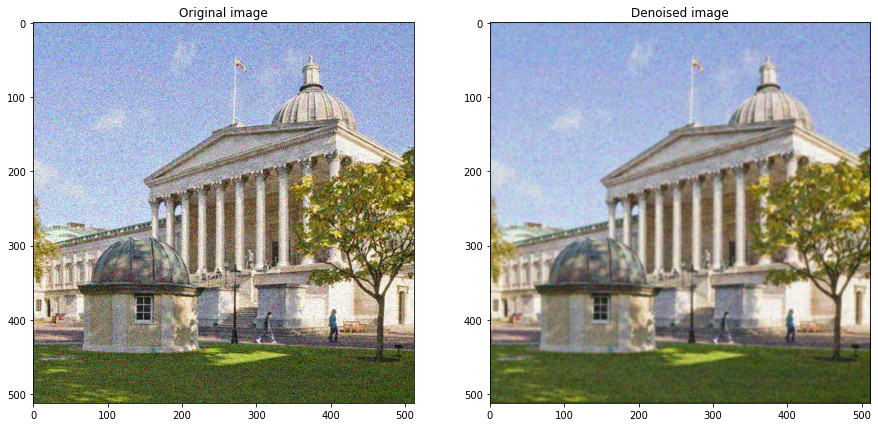

In [4]:
# PATH
noisy_image_filename = "../Datasets/Filtering/noisy_image.png"

# LOAD noisy_image FROM noisy_image_filename
noisy_image = cv2.imread(noisy_image_filename)
# Convert to RGB
noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)
# Normalize the input image
noisy_image = cv2.normalize(noisy_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
# Gaussian denoising 
def denoise_gauss(image):
    # IMPLEMENT THIS FUNCTION
    # Dimension 
    width, height, nchannels = image.shape
    
    denoised_image = np.zeros((width, height, nchannels))
    
    # Filter 
    gaussian_filter = (1 / 273) * np.array([[1,  4,  7,  4, 1],
                                            [4, 16, 26, 16, 4],
                                            [7, 26, 41, 26, 7],
                                            [4, 16, 26, 16, 4],
                                            [1,  4,  7,  4, 1]], np.float32)
    
    # Padding 
    padded_image = np.zeros((width + 4, height + 4, nchannels))
    padded_image[2:-2, 2:-2, :] = image

    # Convolution
    for i in range(0, width):
        for j in range(0, height):
            for k in range(0, nchannels):
                pixel_box = padded_image[(i):(i + 5), (j):(j + 5), k]
                gaussian_convolution = np.abs(np.sum(pixel_box * gaussian_filter))
                denoised_image[i, j, k] = gaussian_convolution
                
    return denoised_image

# Calling the function
denoised_image = denoise_gauss(noisy_image)

# DISPLAY input_image AND denoised_image here

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.set_title("Original image")
ax1.imshow(noisy_image)

ax2.imshow(denoised_image, cmap='gray')
ax2.set_title("Denoised image")

plt.show()

### Part 2b) Implement a pyramidal encoder-decoder to denoise an image.  We provide you pairs of noisy and noise-free image patches of size 128×128 for training and testing. You may use all the infrastructure of Pytorch. The encoder should have 5 levels and double(half) the number of internal activations when reducing (increasing) the spatial resolution. Please use ReLU non-linearities after each layer **(15 points)**
---

Implement following cell, to solve this question.

In [5]:
input_imgs_path = "../Datasets/Denoising/input_noisy_images"
cleaned_imgs_path = "../Datasets/Denoising/target_clean_images"
epochs = 150 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

# Dataset 
class DenoisingDB(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.

        # Get the paths
        input_image_names = os.listdir(input_imgs_path)
        target_image_names = os.listdir(cleaned_imgs_path)
        self.input_imgs_paths = [os.path.join(input_imgs_path, name) for name in input_image_names]
        self.target_imgs_paths = [os.path.join(cleaned_imgs_path, name) for name in target_image_names] 

    def __len__(self):
        # RETURN SIZE OF DATASET
        
        length = len(self.input_imgs_paths)
        
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx

        # Read the image and normalize 
        input_image = cv2.imread(self.input_imgs_paths[idx])
        input_image = cv2.normalize(input_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # Read the image and normalize 
        target_image = cv2.imread(self.target_imgs_paths[idx])
        target_image = cv2.normalize(target_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        # Input and target image
        image = {"input" : np.transpose(input_image[0:128, 0:128], [2, 0, 1]), 
                 "target" : np.transpose(target_image[0:128, 0:128], [2, 0, 1])}

        return image

# Encoder
class Encoder(Module):
  # IMPLEMENT THIS ENCODER CLASS
    def __init__(self):
        super(Encoder, self).__init__()
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.

        # Layer 1
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        # Layer 2
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        # Layer 3
        self.conv3 = nn.Conv2d(12, 24, 3, padding=1)
        # Layer 4
        self.conv4 = nn.Conv2d(24, 48, 3, padding=1)
        # Layer 5
        self.conv5 = nn.Conv2d(48, 96, 3, padding=1)
        # Layer pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self,high_res_image):
        # WRITE YOUR ENCODER ARCHITECTURE HERE
        
        # Layer 1
        x = self.pool(F.relu(self.conv1(high_res_image)))
        # Layer 2
        x = self.pool(F.relu(self.conv2(x)))
        # Layer 3
        x = self.pool(F.relu(self.conv3(x)))
        # Layer 4
        x = self.pool(F.relu(self.conv4(x)))
        # Layer 5
        low_res_image = self.pool(F.relu(self.conv5(x)))

        return low_res_image

# Decoder 
class Decoder(Module):
  # IMPLEMENT THIS DECODER CLASS

    def __init__(self):
        super(Decoder, self).__init__()
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.

        # Layer 1
        self.t_conv1 = nn.ConvTranspose2d(96, 48, 2, stride=2)
        # Layer 2
        self.t_conv2 = nn.ConvTranspose2d(48, 24, 2, stride=2)
        # Layer 3
        self.t_conv3 = nn.ConvTranspose2d(24, 12, 2, stride=2)
        # Layer 4
        self.t_conv4 = nn.ConvTranspose2d(12, 6, 2, stride=2)
        # Layer 5
        self.t_conv5 = nn.ConvTranspose2d(6, 3, 2, stride=2)

    def forward(self,low_res_image):
        # WRITE YOUR DECODER ARCHITECTURE HERE

        # Layer 1
        x = F.relu(self.t_conv1(low_res_image))
        # Layer 2
        x = F.relu(self.t_conv2(x))
        # Layer 3
        x = F.relu(self.t_conv3(x))
        # Layer 4
        x = F.relu(self.t_conv4(x))
        # Layer 5
        denoised_image = torch.sigmoid(self.t_conv5(x))

        return denoised_image
        
def loss_function(input,target):
    # WRITE YOUR DENOISING LOSS FUNCTION HERE
    # Loss function
    loss = nn.MSELoss()
    output = loss(input, target)
    return output

# Models 
encoder = Encoder()
decoder = Decoder() 

# Optimizer
optimizer = torch.optim.Adam(nn.Sequential(encoder, decoder).parameters(), lr=1e-3) # USE THE TORCH API TO WRITE YOUR Stochastic Gradient Descent optimizer function here.

# Dataset 
docs_dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)
# Dataloader
torch_train_docs = DataLoader(docs_dataset,shuffle=True,batch_size=16,num_workers=4)  # YOU CAN CHOOSE YOUR BATCH SIZE

# if GPU available use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# make the models use device
encoder.to(device)
decoder.to(device)

# Keep track of losses
train_loss_list = []
iteration_list = []

# Training 
print("Training.")

for ep in range(epochs):
    # Training loss per epoch
    trainTotalLoss = 0

    for i,data in enumerate(torch_train_docs):
        # WRITE YOUR Denoising TRAINING LOOP HERE.
        #  Data
        input = data["input"].to(device)
        target = data["target"].to(device)        

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        code = encoder(input)
        output = decoder(code)
        loss = loss_function(output, target)
        trainTotalLoss += loss.item()
        loss.backward()
        optimizer.step()

    # Keep track of the loss
    train_loss_list.append(trainTotalLoss)
    iteration_list.append(ep)

    print("Epoch:", ep, "Loss:", trainTotalLoss)

    # fill in your training loop here. Use the loss function and SGD optimizer

print("Finished training.")

# Save the model
PATH = '../Models/model_q2'
torch.save({"Encoder" : encoder.state_dict(), "Decoder" : decoder.state_dict()}, PATH)

Training.
Epoch: 0 Loss: 1.8299714773893356
Epoch: 1 Loss: 1.806915432214737
Epoch: 2 Loss: 1.7658109217882156
Epoch: 3 Loss: 1.6742750704288483
Epoch: 4 Loss: 1.545120283961296
Epoch: 5 Loss: 1.3889817297458649
Epoch: 6 Loss: 1.2548045367002487
Epoch: 7 Loss: 1.1381165087223053
Epoch: 8 Loss: 1.028381384909153
Epoch: 9 Loss: 0.9323293790221214
Epoch: 10 Loss: 0.8606947958469391
Epoch: 11 Loss: 0.804430827498436
Epoch: 12 Loss: 0.7570693641901016
Epoch: 13 Loss: 0.7172247394919395
Epoch: 14 Loss: 0.6875006258487701
Epoch: 15 Loss: 0.6649053618311882
Epoch: 16 Loss: 0.6474303528666496
Epoch: 17 Loss: 0.6333321332931519
Epoch: 18 Loss: 0.6225314140319824
Epoch: 19 Loss: 0.6146461293101311
Epoch: 20 Loss: 0.6091433092951775
Epoch: 21 Loss: 0.6043371185660362
Epoch: 22 Loss: 0.6004384085536003
Epoch: 23 Loss: 0.5970747023820877
Epoch: 24 Loss: 0.5942567363381386
Epoch: 25 Loss: 0.5927446894347668
Epoch: 26 Loss: 0.5901781730353832
Epoch: 27 Loss: 0.5870592519640923
Epoch: 28 Loss: 0.584591

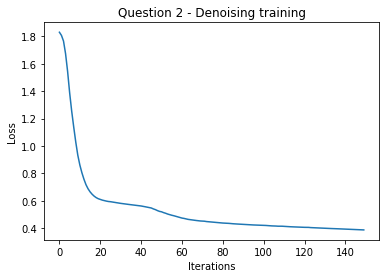

In [6]:
# Plot the loss
plt.figure()
plt.plot(iteration_list, train_loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Question 2 - Denoising training")
plt.show()

### Part 2c) Write a markdown block, comparing the Gaussian and encoder-decoder denoising methods.  Include example output images from each method and discuss which method performs better and where.  You should write no more than half a page.  **(5 points)**
---

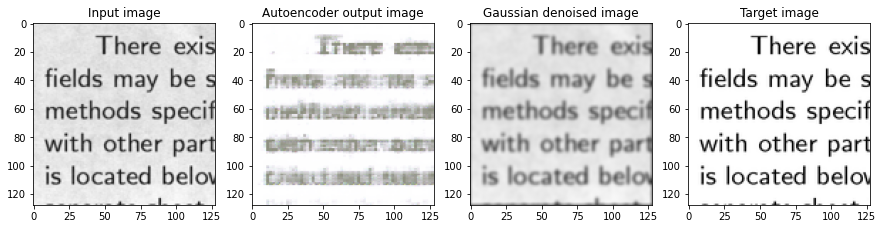

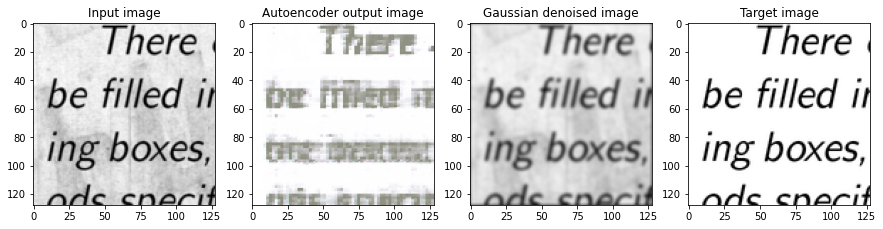

In [7]:
for i,data in enumerate(torch_train_docs):
    # Break after 2 iteration
    if(i > 1):
        break
    
    # Data
    input = data["input"].to(device)
    target = data["target"].to(device)        

    # Forward
    code = encoder(input)
    output = decoder(code)
    
    # Plot the images
    figure, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,4))
    ax1.imshow(input.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    ax1.set_title("Input image")
    ax2.imshow(output.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    ax2.set_title("Autoencoder output image")
    ax3.imshow(denoise_gauss(input.cpu().detach().numpy().transpose(0, 2, 3, 1)[0]))
    ax3.set_title("Gaussian denoised image")
    ax4.imshow(target.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    ax4.set_title("Target image")

plt.show()

The image produced by the Gaussian denoising method reduces image noise and slightly blur the image's detail (the text), as the Gaussian outputs a weighted average of each pixel surrounding itself, with the centre pixels having more weights.

The image produced by the encoder-decoder denoising shows significantly reduced image noise and renders the image's text details, as the autoencoder reduces the spatial resolution of the input in the enc then upsampling in the decoder. 

The Gaussian denoising method produces a better result in retaining the image details such as texts, but not completely remove the image noise. The encoder-decoder denoising method has a better result in removing the image noise; however, the detail of the images such as text is often not preserved very well.

## Question 3: Auto-Encoder


### Part 3a) Implement a convolutional auto-encoder (AE). The loss between in and output should be L2.  You can make use of all the convolution, pooling, back-propagation and build-in functionality of Pytorch here. **(15 points)**
---
Solve this question by implementing the AutoEncoder class below

In [8]:
# Auto-Encoder
class AutoEncoder(Module):
    # IMPLEMENT THIS AUTO-ENCODER CLASS
    def __init__(self,bottleneck_size):
        super(AutoEncoder, self).__init__()
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.
    
        # Encoder
        # Layer 1
        self.conv1 = nn.Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        # Layer 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        # Layer 3
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        # Layer 4
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        # Layer 5
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        # Bottleneck
        self.linear1 = nn.Linear(128 * 4 * 4, bottleneck_size)

        # Decoder
        # Bottleneck
        self.linear2 = nn.Linear(bottleneck_size, 128 * 4 * 4)
        # Layer 1        
        self.d_conv1 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.d_bn1 = nn.BatchNorm2d(64)
        # Layer 2    
        self.d_conv2 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.d_bn2 = nn.BatchNorm2d(32)
        # Layer 3        
        self.d_conv3 = nn.Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.d_bn3 = nn.BatchNorm2d(16)
        # Layer 4        
        self.d_conv4 = nn.Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.d_bn4 = nn.BatchNorm2d(8)
        # Layer 5        
        self.d_conv5 = nn.Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=1)
        
        
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        # Encoder produce the code of the image
        # Layer 1
        x = self.conv1(image)
        x = F.relu(x)
        x = self.bn1(x)
        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        # Layer 3
        x = self.conv3(x)        
        x = F.relu(x)
        x = self.bn3(x)
        # Layer 4
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        # Layer 5
        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn5(x)
        # Layer Bottleneck
        x = x.view(-1, 128 * 4 * 4)
        code = self.linear1(x)
        return code
    
    def decoder(self,code):
        # WRITE DECODER ARCHITECTURE HERE
        # Decoder decodes the code and produce decoded image
        # Layer Bottleneck
        x = self.linear2(code)
        x = F.relu(x)
        x = x.view(-1, 128, 4, 4)
        # Layer 1
        x = F.interpolate(x, scale_factor=2)
        x = self.d_conv1(x)
        x = F.relu(x)
        x = self.d_bn1(x)
        # Layer 2
        x = F.interpolate(x, scale_factor=2)
        x = self.d_conv2(x)
        x = F.relu(x)
        x = self.d_bn2(x)
        # Layer 3        
        x = F.interpolate(x, scale_factor=2)
        x = self.d_conv3(x)
        x = F.relu(x)
        x = self.d_bn3(x)
        # Layer 4
        x = F.interpolate(x, scale_factor=2)
        x = self.d_conv4(x)
        x = F.relu(x)
        x = self.d_bn4(x)
        # Layer 5        
        x = F.interpolate(x, scale_factor=2)
        x = self.d_conv5(x) 
        decoded_image = torch.sigmoid(x)
        
        return decoded_image
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        # Forward the encoder-decoder
        x = self.encoder(image)
        decoded_image = self.decoder(x)
        
        return decoded_image

### Part 3b) Test it on the CelebA and MNIST dataset by encoding and decoding their first 5 samples. Compile results showing for each of the dataset and for each sample the input and the AE reconstruction,side-by-side. **(5 points)**
---
Solve this question by implementing the data classes and your training loop

#### Dataloading Cell - this will be used for both Q3 and Q4

In [9]:
class CelebA(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    def __init__(self, dataset_path=""):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.

        # Get the paths
        input_image_names = os.listdir(dataset_path)
        self.input_image_paths = [os.path.join(dataset_path, name) for name in input_image_names]

    def __len__(self):
        # RETURN SIZE OF DATASET
        
        length = len(self.input_image_paths)
        
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx

        # Read the image
        image = cv2.imread(self.input_image_paths[idx])
        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Normalize the image
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)        
        # Centre crop the image to 128x128
        image = self.centreCrop(image, 128, 128)
        # Transpose to have channel first
        image = np.transpose(image, [2, 0, 1])
        
        return image
    
    # Helper Function for cropping the centre of image
    def centreCrop(self, image, crop_x, crop_y):
        width, height = image.shape[0:2]
        x = width // 2 - crop_x // 2
        y = height // 2 - crop_y // 2

        return image[x:(x + crop_x), y:(y + crop_y), :]

class MNIST(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    def __init__(self, dataset_path=""):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        # Get the paths
        input_image_names = os.listdir(dataset_path)
        self.input_image_paths = [os.path.join(dataset_path, name) for name in input_image_names]

    def __len__(self):
        # RETURN SIZE OF DATASET
        
        length = len(self.input_image_paths)
        
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        # Read the image
        image = cv2.imread(self.input_image_paths[idx])
        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Normalize the image
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # Resize the image to 128x128
        image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
        # Transpose to have channel first
        image = np.transpose(image, [2, 0, 1])

        return image

# Paths, datasets and dataloaders
celeba_train_data_path = "../Datasets/CelebA/train/"
celeba_train_dataset = CelebA(celeba_train_data_path)
torch_train_celeba = DataLoader(celeba_train_dataset,shuffle=True,batch_size=64,num_workers=4)  # YOU CAN CHOOSE YOUR BATCH SIZE

celeba_validation_data_path = "../Datasets/CelebA/validation/"
celeba_validation_dataset = CelebA(celeba_validation_data_path)
torch_validation_celeba = DataLoader(celeba_validation_dataset,shuffle=True,batch_size=64,num_workers=4)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_train_data_path = "../Datasets/MNIST/train/"
mnist_train_dataset = MNIST(mnist_train_data_path)
torch_train_mnist = DataLoader(mnist_train_dataset,shuffle=True,batch_size=64,num_workers=4)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_validation_data_path = "../Datasets/MNIST/validation/"
mnist_validation_dataset = MNIST(mnist_validation_data_path)
torch_validation_mnist = DataLoader(mnist_validation_dataset,shuffle=True,batch_size=64,num_workers=4)  # YOU CAN CHOOSE YOUR BATCH SIZE

#### Auto-Encoder training cell

In [10]:
def reconstruction_loss(input,target):
    
    # WRITE YOUR L2 RECONSTRUCTION LOSS HERE
    loss = nn.MSELoss()
    recon_loss = loss(input, target)
    
    return recon_loss

epochs = 100 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

mnist_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder = AutoEncoder(mnist_bottleneck_size)
celeba_autoencoder = AutoEncoder(celeba_bottleneck_size)

# OPTIMIZER SECTION: USE THE TORCH API TO WRITE YOUR OPTIMIZER FUNCTION BELOW
mnist_optimizer = torch.optim.Adam(mnist_autoencoder.parameters(), lr=1e-3)  
celeba_optimizer = torch.optim.Adam(celeba_autoencoder.parameters(), lr=1e-3)

# if GPU is available use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# make the models use device
celeba_autoencoder.to(device)
mnist_autoencoder.to(device)

# Keep track of losses
celeba_train_loss_list = []
celeba_validation_loss_list = []
celeba_iteration_list = []

mnist_train_loss_list = []
mnist_validation_loss_list = []
mnist_iteration_list = []

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

print("CelebA training.")

for ep in range(epochs):
    # Loss per epoch
    trainTotalLoss = 0
    validTotalLoss = 0
    
    for i,data in enumerate(torch_train_celeba):
        # WRITE YOUR CelebA TRAINING LOOP HERE.

        # Break after 10 minibatches
        if (i > 9):
            break

        #  Data
        data = data.to(device)

        # Zero the parameter gradients
        celeba_optimizer.zero_grad()
        
        # Forward + backward + optimize
        output = celeba_autoencoder(data)
        loss = reconstruction_loss(output, data)
        trainTotalLoss += loss.item()
        loss.backward()
        celeba_optimizer.step()

    # Keep track of losses
    celeba_train_loss_list.append(trainTotalLoss)
    celeba_iteration_list.append(ep)
    
    print("Epoch:", ep, "Loss:", trainTotalLoss)

    for i,data in enumerate(torch_validation_celeba):
        # WRITE YOUR CelebA VALIDATION LOOP HERE.
        
        # Break after 1 minibatch
        if (i > 0):
            break

        # Data + Forward + Loss
        data = data.to(device)
        output = celeba_autoencoder(data)
        loss = reconstruction_loss(output, data)
        validTotalLoss += loss.item()

    # Keep track of losses
    celeba_validation_loss_list.append(validTotalLoss)
    
print("Finsih CelebA training.")

print("MNIST training.")
for ep in range(epochs):

    trainTotalLoss = 0
    validTotalLoss = 0
    
    for i,data in enumerate(torch_train_mnist):
        # WRITE YOUR MNIST TRAINING LOOP HERE.

        # Break after 10 minibatches
        if (i > 9):
            break

        #  Data
        data = data.to(device)

        # Zero the parameter gradients
        mnist_optimizer.zero_grad()

        # Forward + backward + optimize
        output = mnist_autoencoder(data)
        loss = reconstruction_loss(output, data)
        trainTotalLoss += loss.item()
        loss.backward()
        mnist_optimizer.step()   

    # Keep track of losses
    mnist_train_loss_list.append(trainTotalLoss)
    mnist_iteration_list.append(ep)

    print("Epoch:", ep, "Loss:", trainTotalLoss)

    for i,data in enumerate(torch_validation_mnist):
        # WRITE YOUR MNIST VALIDATION LOOP HERE.

        # Break after 1 minibatch
        if (i > 0):
            break

        # Data + Forward + Loss
        data = data.to(device)
        output = mnist_autoencoder(data)
        loss = reconstruction_loss(output, data)
        validTotalLoss += loss.item()

    # Keep track of losses
    mnist_validation_loss_list.append(validTotalLoss)

print("Finsih MNIST training.")

# Save the models
PATH = '../Models/model_q3_celeba'
torch.save(celeba_autoencoder.state_dict(), PATH)

PATH = '../Models/model_q3_mnist'
torch.save(mnist_autoencoder.state_dict(), PATH)

CelebA training.
Epoch: 0 Loss: 0.6799224764108658
Epoch: 1 Loss: 0.4265131875872612
Epoch: 2 Loss: 0.3512344993650913
Epoch: 3 Loss: 0.2928635124117136
Epoch: 4 Loss: 0.2649991288781166
Epoch: 5 Loss: 0.23647167347371578
Epoch: 6 Loss: 0.2193268220871687
Epoch: 7 Loss: 0.2015793491154909
Epoch: 8 Loss: 0.18232871405780315
Epoch: 9 Loss: 0.18523772060871124
Epoch: 10 Loss: 0.17423399537801743
Epoch: 11 Loss: 0.15797212347388268
Epoch: 12 Loss: 0.16006926354020834
Epoch: 13 Loss: 0.1518940096721053
Epoch: 14 Loss: 0.15164991188794374
Epoch: 15 Loss: 0.14806238655000925
Epoch: 16 Loss: 0.14729880169034004
Epoch: 17 Loss: 0.1388265397399664
Epoch: 18 Loss: 0.13808050006628036
Epoch: 19 Loss: 0.1391696548089385
Epoch: 20 Loss: 0.13921286910772324
Epoch: 21 Loss: 0.1336301788687706
Epoch: 22 Loss: 0.13516440987586975
Epoch: 23 Loss: 0.12901422381401062
Epoch: 24 Loss: 0.128559990786016
Epoch: 25 Loss: 0.12247929628938437
Epoch: 26 Loss: 0.12342355027794838
Epoch: 27 Loss: 0.1226874580606818

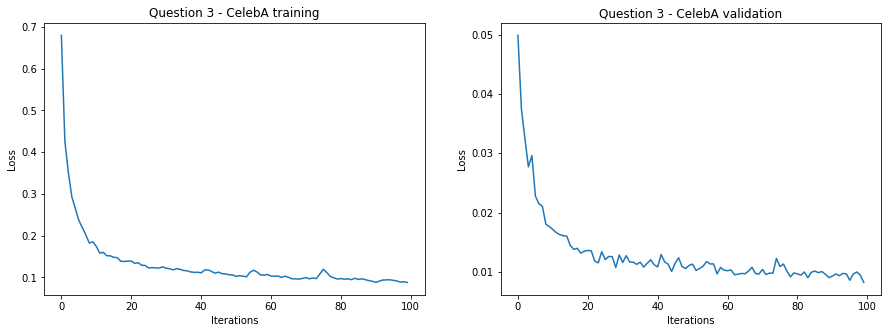

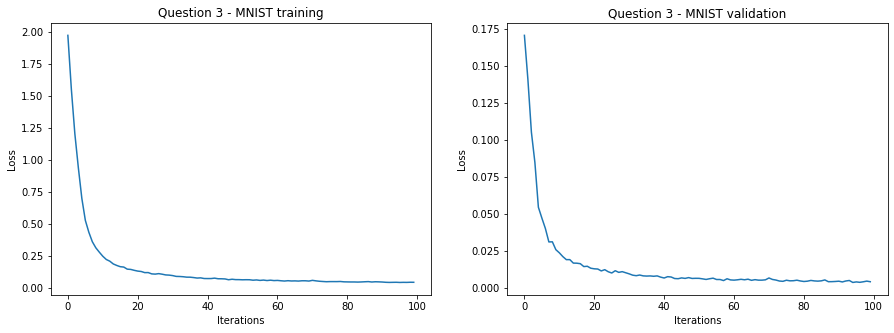

In [11]:
# Plot the losses 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.plot(celeba_iteration_list, celeba_train_loss_list)
ax1.set_title("Question 3 - CelebA training")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(celeba_iteration_list, celeba_validation_loss_list)
ax2.set_title("Question 3 - CelebA validation")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.plot(mnist_iteration_list, mnist_train_loss_list)
ax1.set_title("Question 3 - MNIST training")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(mnist_iteration_list, mnist_validation_loss_list)
ax2.set_title("Question 3 - MNIST validation")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

#### Auto-Encoder testing cell

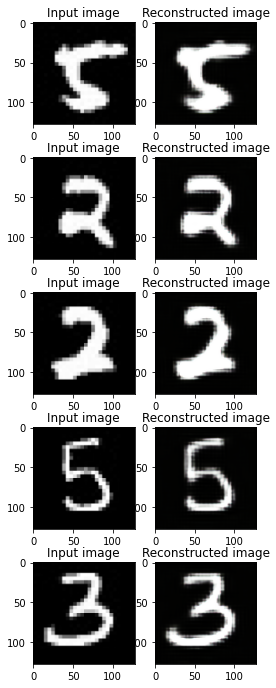

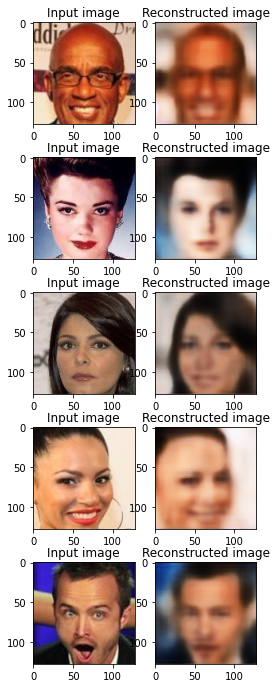

In [12]:
# AFTER YOUR MODEL IS TRAINED, USE THIS SECTION TO ENCODE-DECODE 5 IMAGES EACH FROM CelebA and MNIST.
# PRESENT THE RESULTS IN TWO 5X2 GRID LAYOUTS -- One grid FOR CelebA and another grid for MNIST.
# Grid Format:
# USE 5 ROWS, 2 COLUMNS.
# EACH ROW CORRESPONDS TO 1 TEST IMAGE. FIRST COLUMN SHOULD BE INPUT IMAGE, SECOND COLUMN SHOULD BE RECONSTRUCTED IMAGE

figure, axes = plt.subplots(5,2, figsize=(4,12))
axes = axes.ravel()
for i,data in enumerate(torch_validation_mnist):
    if(i > 4):
        break
    data = data.to(device)
    output = mnist_autoencoder(data)

    axes[2*i].imshow(data.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[2*i].set_title("Input image")
    axes[2*i+1].imshow(output.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[2*i+1].set_title("Reconstructed image")

figure, axes = plt.subplots(5,2, figsize=(4,12))
axes = axes.ravel()
for i,data in enumerate(torch_validation_celeba):
    if(i > 4):
        break
    data = data.to(device)
    output = celeba_autoencoder(data)

    axes[2*i].imshow(data.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[2*i].set_title("Input image")
    axes[2*i+1].imshow(output.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[2*i+1].set_title("Reconstructed image")

plt.show()


## Question 4: Variational AutoEncoder (VAE)



### Part 4a) Add the reparametrization trick to turn the AE into a variational auto-encoder (VAE) **(10 points)**
---
Solve this question by completing the VAE class below

In [13]:
class VAE(AutoEncoder):
    # IMPLEMENT THIS VAE CLASS
    def __init__(self,bottleneck_size):
        super(VAE, self).__init__(bottleneck_size)
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.

        # Encoder      
        # Layer 1        
        self.conv1 = nn.Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        # Layer 2      
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        # Layer 3        
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        # Layer 4        
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        # Layer 5        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        # 2 bottleneck layers
        self.mean_linear = nn.Linear(128 * 4 * 4, bottleneck_size)
        self.logVar_linear = nn.Linear(128 * 4 * 4, bottleneck_size)

  
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE.
        # Layer 1     
        x = self.conv1(image)
        x = F.relu(x)
        x = self.bn1(x)
        # Layer 2        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        # Layer 3        
        x = self.conv3(x)        
        x = F.relu(x)
        x = self.bn3(x)
        # Layer 4        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        # Layer 5        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn5(x)

        # Reshape
        x = x.view(-1, 128 * 4 * 4)

        # 2 bottleneck layers
        mu = self.mean_linear(x)
        std = torch.exp(0.5 * self.logVar_linear(x))
        return mu, std
    
    def reparametrization_trick(self,mu,std):
        # WRITE THE REPARAMETRIZATION TRICK HERE.

        esp = torch.randn(std.shape).to(device)
        z = mu + esp * std

        return z
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        
        mu, std = self.encoder(image)
        code = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(code)
        
        return decoded_image, mu, std

### Part 4b) Test it on the CelebA and MNIST dataset by generating 5 samples of each to be shown in no more than half a page. **(5 points)**
---

#### VAE training cell

In [20]:
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

def kl_divergence_loss(mu,std):
    
    # WRITE YOUR KL-DIVERGENCE LOSS CODE HERE
    kl_loss = torch.mean(mu ** 2 + std ** 2 - torch.log(std ** 2) - 1)

    return kl_loss

def reconstruction_loss(input,target):
    
    # WRITE YOUR L2 RECONSTRUCTION LOSS HERE
    loss = nn.MSELoss(reduction="mean")
    recon_loss = loss(input, target)
    
    return recon_loss

epochs = 100 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

mnist_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder = VAE(mnist_bottleneck_size)
celeba_autoencoder = VAE(celeba_bottleneck_size)

# USE THE TORCH API TO WRITE YOUR OPTIMIZER HERE
mnist_optimizer = torch.optim.Adam(mnist_autoencoder.parameters(), lr=1e-3) 
celeba_optimizer = torch.optim.Adam(celeba_autoencoder.parameters(), lr=1e-3)

# if GPU is available use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# make the models use device
celeba_autoencoder.to(device)
mnist_autoencoder.to(device)

# Keep track of losses
celeba_train_loss_list = []
celeba_validation_loss_list = []
celeba_iteration_list = []

mnist_train_loss_list = []
mnist_validation_loss_list = []
mnist_iteration_list = []

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

print("CelebA training.")

for ep in range(epochs):

    # losses per epoch
    trainTotalLoss = 0
    validTotalLoss = 0
  
    for i,data in enumerate(torch_train_celeba):
        # WRITE YOUR CelebA TRAINING LOOP HERE.

        # Break after 10 minibatches
        if (i > 9):
            break

        #  Data
        data = data.to(device)

        # Zero the parameter gradients
        celeba_optimizer.zero_grad()

        # Forward + backward + optimize
        output, mu, std = celeba_autoencoder(data)
        loss1 = reconstruction_loss(output, data)
        loss2 = kl_divergence_loss(mu, std)
        loss = loss1 + loss2
        trainTotalLoss += loss.item()
        loss.backward()
        celeba_optimizer.step()

    # Keep track of losses
    celeba_train_loss_list.append(trainTotalLoss)
    celeba_iteration_list.append(ep)    

    print("Epoch:", ep, "Loss:", trainTotalLoss)

    for i,data in enumerate(torch_validation_celeba):
        # WRITE YOUR CelebA VALIDATION LOOP HERE.

        # Break after 1 minibatch
        if (i > 0):
            break

        # Data + Forward + Loss 
        data = data.to(device)   
        output, mu, std = celeba_autoencoder(data)
        loss1 = reconstruction_loss(output, data)
        loss2 = kl_divergence_loss(mu, std)
        loss = loss1 + loss2
        validTotalLoss += loss.item()

    # Keep track of losses
    celeba_validation_loss_list.append(validTotalLoss)

print("Finsih CelebA training.")

print("MNIST training.")

for ep in range(epochs):

    # losses per epoch
    trainTotalLoss = 0
    validTotalLoss = 0
    
    for i,data in enumerate(torch_train_mnist):
        # WRITE YOUR MNIST TRAINING LOOP HERE.

        # Break after 10 minibatches
        if (i > 9):
            break

        #  Data
        data = data.to(device)

        # Zero the parameter gradients
        mnist_optimizer.zero_grad()

        # Forward + backward + optimize
        output, mu, std = mnist_autoencoder(data)
        loss1 = reconstruction_loss(output, data)
        loss2 = kl_divergence_loss(mu, std)
        loss = loss1 + loss2
        trainTotalLoss += loss.item()
        loss.backward()
        mnist_optimizer.step()   

    # Keep track of losses
    mnist_train_loss_list.append(trainTotalLoss)
    mnist_iteration_list.append(ep)

    print("Epoch:", ep, "Loss:", trainTotalLoss)

    for i,data in enumerate(torch_validation_mnist):
        # WRITE YOUR MNIST VALIDATION LOOP HERE.

        # Break after 1 minibatch
        if (i > 0):
            break

        # Data + Forward + Loss
        data = data.to(device)        
        output, mu, std = mnist_autoencoder(data)
        loss1 = reconstruction_loss(output, data)
        loss2 = kl_divergence_loss(mu, std)
        loss = loss1 + loss2
        validTotalLoss += loss.item()

    mnist_validation_loss_list.append(validTotalLoss)

print("Finsih MNIST training.")

# Save the models

PATH = '../Models/model_q4_celeba'
torch.save(celeba_autoencoder.state_dict(), PATH)

PATH = '../Models/model_q4_mnist'
torch.save(mnist_autoencoder.state_dict(), PATH)

CelebA training.
Epoch: 0 Loss: 3.6729683876037598
Epoch: 1 Loss: 1.355594053864479
Epoch: 2 Loss: 1.0295920744538307
Epoch: 3 Loss: 0.9390821009874344
Epoch: 4 Loss: 0.8214705213904381
Epoch: 5 Loss: 0.7454068809747696
Epoch: 6 Loss: 0.715910479426384
Epoch: 7 Loss: 0.6780712306499481
Epoch: 8 Loss: 0.6611046120524406
Epoch: 9 Loss: 0.6121563240885735
Epoch: 10 Loss: 0.6098589301109314
Epoch: 11 Loss: 0.5981767810881138
Epoch: 12 Loss: 0.6094269715249538
Epoch: 13 Loss: 0.6575466245412827
Epoch: 14 Loss: 0.6456874422729015
Epoch: 15 Loss: 0.6172740161418915
Epoch: 16 Loss: 0.6474201567471027
Epoch: 17 Loss: 0.5998793058097363
Epoch: 18 Loss: 0.5797889232635498
Epoch: 19 Loss: 0.5649935603141785
Epoch: 20 Loss: 0.5598016567528248
Epoch: 21 Loss: 0.5453625619411469
Epoch: 22 Loss: 0.5583097003400326
Epoch: 23 Loss: 0.5712038613855839
Epoch: 24 Loss: 0.5667376220226288
Epoch: 25 Loss: 0.5841902457177639
Epoch: 26 Loss: 0.6121525950729847
Epoch: 27 Loss: 0.5827075690031052
Epoch: 28 Loss:

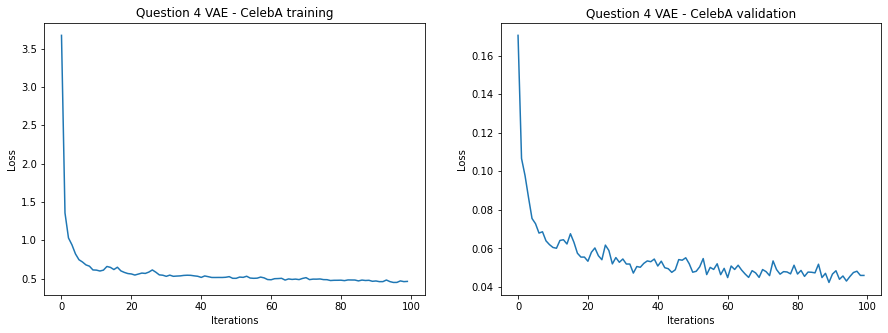

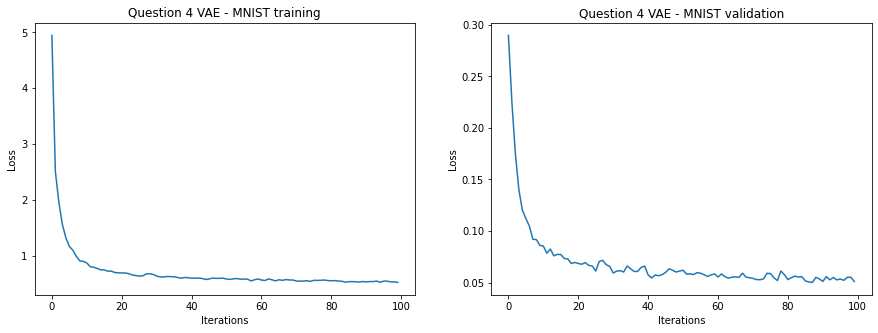

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.plot(celeba_iteration_list, celeba_train_loss_list)
ax1.set_title("Question 4 VAE - CelebA training")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(celeba_iteration_list, celeba_validation_loss_list)
ax2.set_title("Question 4 VAE - CelebA validation")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.plot(mnist_iteration_list, mnist_train_loss_list)
ax1.set_title("Question 4 VAE - MNIST training")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(mnist_iteration_list, mnist_validation_loss_list)
ax2.set_title("Question 4 VAE - MNIST validation")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

#### VAE testing cell

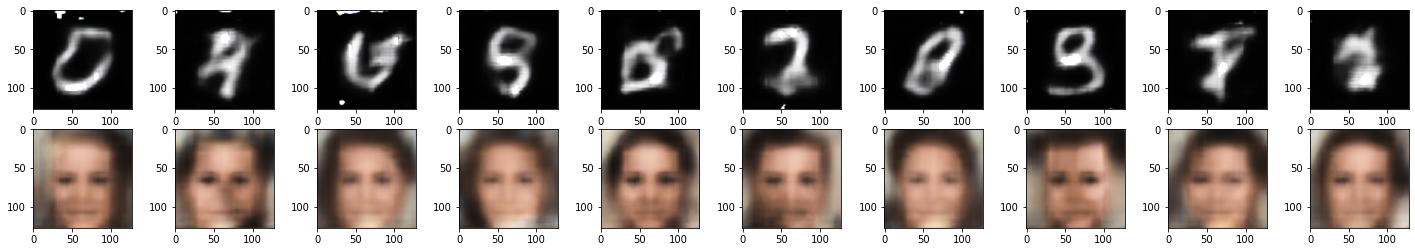

In [22]:
number_of_samples = 10

random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,mnist_bottleneck_size).to(device)
    
    ### Use the random code, to generate MNIST images with your trained Variational Auto-Encoder
    random_normal_decoded_image = mnist_autoencoder.decoder(random_normal_code)
    random_mnist_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])

random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_bottleneck_size).to(device)
    
    ## Use the random code, to generate CelebA images with your trained Variational Auto-Encoder
    random_normal_decoded_image = celeba_autoencoder.decoder(random_normal_code)
    random_celeba_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])

### Present the images in a single grid of 2x10.
### Top row is for MNIST images, bottom for CelebA
fig, axes = plt.subplots(2,10,figsize=(25,4))
axes = axes.ravel()
for i in range(number_of_samples):
    axes[i].imshow(random_mnist_images[i])
    axes[i+10].imshow(random_celeba_images[i])

### Part 4c) Compare the samples from the VAE to the samples of the AE and explain in one sentence what is the difference. **(3 points)**
---
Solve this question by completing and running the cell below with your trained auto-encoder

First 2 rows are the Autoencoder Samples
Second 2 rows are the Variational Autoencoder Samples


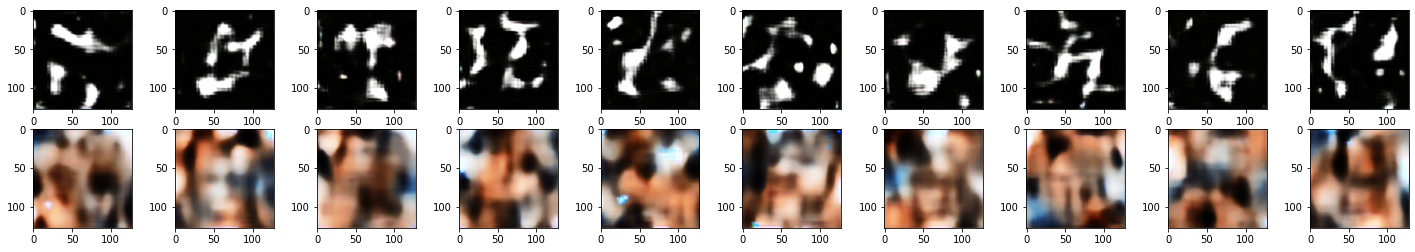

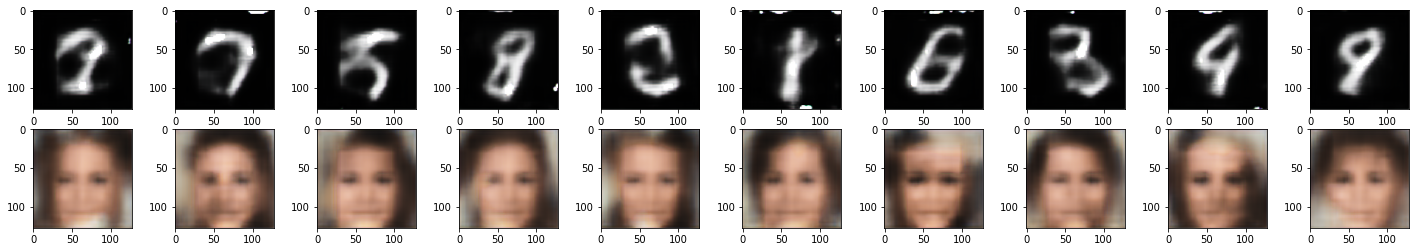

In [23]:
number_of_samples = 10

# Prepare the models
celeba_AE = AutoEncoder(celeba_bottleneck_size)
PATH = '../Models/model_q3_celeba'
celeba_AE.load_state_dict(torch.load(PATH))
celeba_AE.to(device)

mnist_AE = AutoEncoder(mnist_bottleneck_size)
PATH = '../Models/model_q3_mnist'
mnist_AE.load_state_dict(torch.load(PATH))
mnist_AE.to(device)

celeba_VAE = VAE(celeba_bottleneck_size)
PATH = '../Models/model_q4_celeba'
celeba_VAE.load_state_dict(torch.load(PATH))
celeba_VAE.to(device)

mnist_VAE = VAE(mnist_bottleneck_size)
PATH = '../Models/model_q4_mnist'
mnist_VAE.load_state_dict(torch.load(PATH))
mnist_VAE.to(device)

# Keep track of image generated
AE_random_mnist_images =[]
VAE_random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,mnist_bottleneck_size).to(device)
    
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    random_normal_decoded_image = mnist_AE.decoder(random_normal_code)
    AE_random_mnist_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    random_normal_decoded_image = mnist_VAE.decoder(random_normal_code)
    VAE_random_mnist_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    
# Keep track of image generated
AE_random_celeba_images = []
VAE_random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_bottleneck_size).to(device)
    
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    random_normal_decoded_image = celeba_AE.decoder(random_normal_code)
    AE_random_celeba_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    random_normal_decoded_image = celeba_VAE.decoder(random_normal_code)
    VAE_random_celeba_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    
### Present the images in a single grid of 2x10.
### Top row is for MNIST images, bottom for CelebA
print("First 2 rows are the Autoencoder Samples")
print("Second 2 rows are the Variational Autoencoder Samples")
fig, axes = plt.subplots(2,10,figsize=(25,4))
axes = axes.ravel()
for i in range(number_of_samples):
    axes[i].imshow(AE_random_mnist_images[i])
    axes[i+10].imshow(AE_random_celeba_images[i])

fig, axes = plt.subplots(2,10,figsize=(25,4))
axes = axes.ravel()
for i in range(number_of_samples):
    axes[i].imshow(VAE_random_mnist_images[i])
    axes[i+10].imshow(VAE_random_celeba_images[i])

plt.show()

The regular autoencoder reconstructs output images using generated random code does not make new meaningful sample output, as the regular autoencoder only learns to an encoded representation of the input image and reconstruct decoded image, whereas samples of the variational autoencoder are unseen data from before, as the variational autoencoder is a generative model that learns the data associated with probability distribution (Gaussian) and learns parameters of the distribution.

### Part 4d) If it is difficult to make VAE optimization converge, please try Stochastic Gradient Descent, and ADAM. Write no more than three sentences and one plot to argue why one optimizer is better than the other while nothing else was changed. **(2 points)**
---

Stochastic Gradient Descent uses the same learning rate for all parameters, whereas ADAM computes adaptive learning rates for each parameter in the neural network. In the case of the many high dimensional parameters need to be optimized, the descent direction for Stochastic Gradient Descent is updated per training example which is prone to not converge fast enough or trapped in a local minimum. And in other cases, ADAM is updated per batch and is more likely to converge into the global minimum.


### Part 4e) Modify your VAE training to use this VGG Perceptual loss, instead of reconstruction loss.  For this loss, you can use the activation from any of then layers of VGG - you can choose your list of VGG layers to use, to generate the best results. **(10 points)**
---
Solve this question by writing the VGG Perceptual Loss in the place indicated below

#### VGG Perceptual Loss definition

In [24]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        vgg = torchvision.models.vgg11(pretrained=True)
        
        # VGG LAYER SELECTION CODE: YOU CAN USE YOUR CHOICE OF VGG-LAYER TO HELP TRAINING, BY ADDING TO blocks AS ILLUSTRATED BELOW.
        blocks.append(vgg.features[:4].eval()) # THIS GIVES ACTIVATION OF VGG LAYER 4
        blocks.append(vgg.features[4:9].eval()) # THIS GIVES ACTIVATION OF VGG LAYER 9
        
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
                
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))

    def forward(self, input, target):
        # input = input.repeat(1, 3, 1, 1)
        # target = target.repeat(1, 3, 1, 1)

        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        
        # YOU CAN CHANGE THIS SIZE IF YOU WANT TO, INSTEAD OF 224 x 224. CHOOSE YOUR PARAMETERS TO GENERATE BEST RESULTS.
        input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
        target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
                
        # WRITE YOUR VGG PERCEPTUAL LOSS CODE HERE
        x = input
        y = target

        x1 = self.blocks[0](x)
        y1 = self.blocks[0](y)

        x2 = self.blocks[1](x1)
        y2 = self.blocks[1](y1)
        
        loss = nn.MSELoss()
        vgg_perceptual_loss = 2e-3 * (loss(x1, y1) + loss(x2, y2))

        return vgg_perceptual_loss

#### Training Cell with VGG Loss

In [33]:
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

epochs = 50 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

# USE THE TORCH API TO WRITE YOUR OPTIMIZER HERE

mnist_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder = VAE(mnist_bottleneck_size)
celeba_autoencoder = VAE(celeba_bottleneck_size)

mnist_optimizer = torch.optim.Adam(mnist_autoencoder.parameters(), lr=1e-3)  
celeba_optimizer = torch.optim.Adam(celeba_autoencoder.parameters(), lr=1e-3) 

# if GPU is available use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()
# make the models use device
celeba_autoencoder.to(device)
mnist_autoencoder.to(device)

# Keep track of losses
celeba_train_loss_list = []
celeba_validation_loss_list = []
celeba_iteration_list = []

mnist_train_loss_list = []
mnist_validation_loss_list = []
mnist_iteration_list = []

# VGG Perceptual Loss
vgg_perceptual_loss = VGGPerceptualLoss()
vgg_perceptual_loss.to(device)


# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

print("CelebA training.")

for ep in range(epochs):
    
    # losses per epoch
    trainTotalLoss = 0
    validTotalLoss = 0
  
    for i,data in enumerate(torch_train_celeba):
        # WRITE YOUR CelebA TRAINING LOOP HERE.

        # Break after 10 minibatches
        if (i > 9):
            break

        #  Data
        data = data.to(device)

        # Zero the parameter gradients
        celeba_optimizer.zero_grad()

        # Forward + backward + optimize
        output, mu, std = celeba_autoencoder(data)
        loss = vgg_perceptual_loss(output, data) + 0.1 * kl_divergence_loss(mu,std)
        trainTotalLoss += loss.item()
        loss.backward()
        celeba_optimizer.step()

    # Keep track of losses
    celeba_train_loss_list.append(trainTotalLoss)
    celeba_iteration_list.append(ep)    

    print("Epoch:", ep, "Loss:", trainTotalLoss)

print("Finsih CelebA training.")

print("MNIST training.")

for ep in range(epochs):

    # losses per epoch
    trainTotalLoss = 0
    validTotalLoss = 0
    
    for i,data in enumerate(torch_train_mnist):
        # WRITE YOUR MNIST TRAINING LOOP HERE.

        # Break after 10 minibatches
        if (i > 9):
            break

        #  Data
        data = data.to(device)

        # Zero the parameter gradients
        mnist_optimizer.zero_grad()

        # Forward + backward + optimize
        output, mu, std = mnist_autoencoder(data)
        loss = vgg_perceptual_loss(output, data) + 0.1 * kl_divergence_loss(mu,std)
        trainTotalLoss += loss.item()
        loss.backward()
        mnist_optimizer.step()   

    # Keep track of losses
    mnist_train_loss_list.append(trainTotalLoss)
    mnist_iteration_list.append(ep)

    print("Epoch:", ep, "Loss:", trainTotalLoss)

print("Finsih MNIST training.")

# Save the models
PATH = '../Models/model_q4_vgg_celeba'
torch.save(celeba_autoencoder.state_dict(), PATH)

PATH = '../Models/model_q4_vgg_mnist'
torch.save(mnist_autoencoder.state_dict(), PATH)

CelebA training.
Epoch: 0 Loss: 0.8059185072779655
Epoch: 1 Loss: 0.41926853731274605
Epoch: 2 Loss: 0.3571135848760605
Epoch: 3 Loss: 0.3312985301017761
Epoch: 4 Loss: 0.3197247125208378
Epoch: 5 Loss: 0.3105908576399088
Epoch: 6 Loss: 0.30649349838495255
Epoch: 7 Loss: 0.3049322981387377
Epoch: 8 Loss: 0.3048016242682934
Epoch: 9 Loss: 0.30265429615974426
Epoch: 10 Loss: 0.29682612232863903
Epoch: 11 Loss: 0.30351839400827885
Epoch: 12 Loss: 0.2975803930312395
Epoch: 13 Loss: 0.29716329276561737
Epoch: 14 Loss: 0.29420460388064384
Epoch: 15 Loss: 0.2951732203364372
Epoch: 16 Loss: 0.29330581426620483
Epoch: 17 Loss: 0.2935036886483431
Epoch: 18 Loss: 0.2904470432549715
Epoch: 19 Loss: 0.28783033788204193
Epoch: 20 Loss: 0.28948425129055977
Epoch: 21 Loss: 0.28678251430392265
Epoch: 22 Loss: 0.28792074136435986
Epoch: 23 Loss: 0.2836146913468838
Epoch: 24 Loss: 0.28937849402427673
Epoch: 25 Loss: 0.29771626740694046
Epoch: 26 Loss: 0.2896870654076338
Epoch: 27 Loss: 0.284419197589159


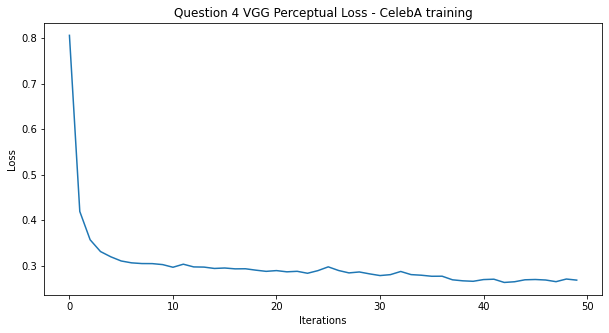

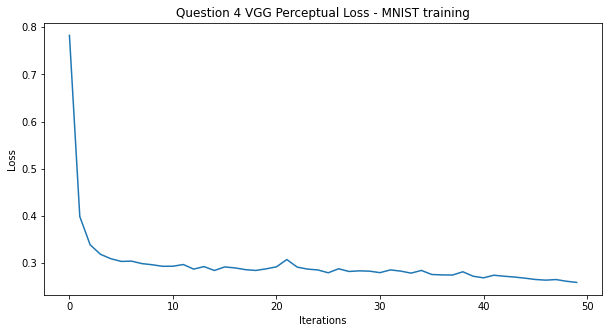

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(celeba_iteration_list, celeba_train_loss_list)
plt.title("Question 4 VGG Perceptual Loss - CelebA training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10, 5))
plt.plot(celeba_iteration_list, mnist_train_loss_list)
plt.title("Question 4 VGG Perceptual Loss - MNIST training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()

#### Testing Cell for VAE with VGG Perceptual Loss

First 2 rows are the Variational Autoencoder with Perceptual Loss Samples
Second 2 rows are the Regular Variational Autoencoder Samples


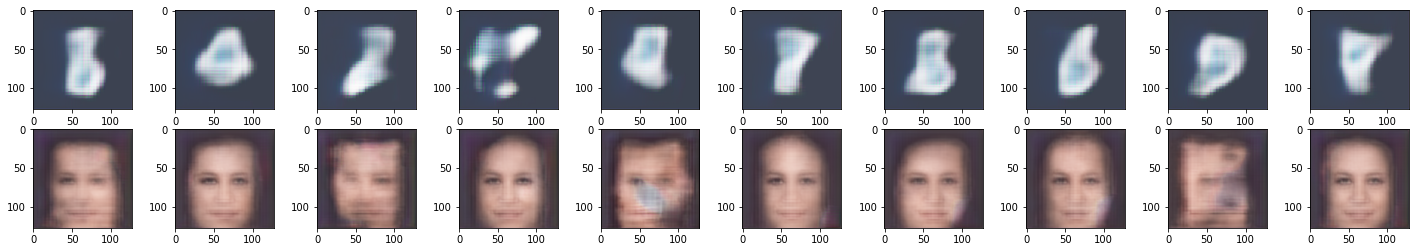

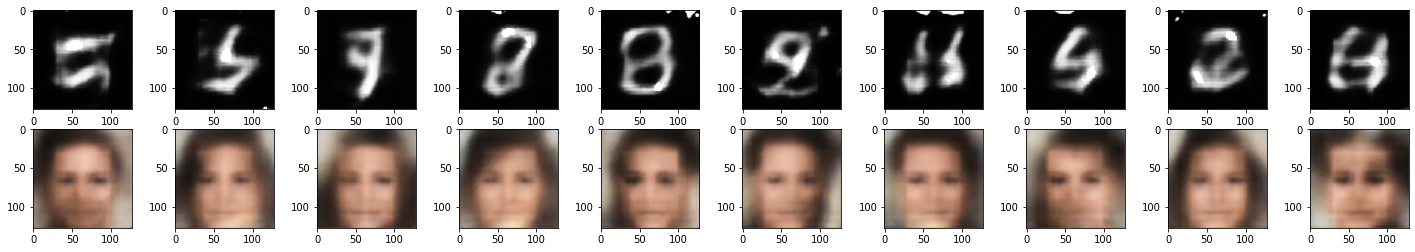

In [39]:
number_of_samples = 10

# Prepare the models
celeba_VAE = VAE(celeba_bottleneck_size)
PATH = '../Models/model_q4_celeba'
celeba_VAE.load_state_dict(torch.load(PATH))
celeba_VAE.to(device)

mnist_VAE = VAE(mnist_bottleneck_size)
PATH = '../Models/model_q4_mnist'
mnist_VAE.load_state_dict(torch.load(PATH))
mnist_VAE.to(device)

random_mnist_images =[]
VAE_random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,mnist_bottleneck_size).to(device)
    
    ### Use the random code, to generate MNIST images with your trained Variational Auto-Encoder
    random_normal_decoded_image = mnist_autoencoder.decoder(random_normal_code)
    random_mnist_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    random_normal_decoded_image = mnist_VAE.decoder(random_normal_code)
    VAE_random_mnist_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    
random_celeba_images = []
VAE_random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_bottleneck_size).to(device)
    
    ### Use the random code, to generate CelebA images with your trained Variational Auto-Encoder
    random_normal_decoded_image = celeba_autoencoder.decoder(random_normal_code)
    random_celeba_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    random_normal_decoded_image = celeba_VAE.decoder(random_normal_code)
    VAE_random_celeba_images.append(random_normal_decoded_image.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    
### Present the images in a single grid of 2x10.
### Top row is for MNIST images, bottom for CelebA
print("First 2 rows are the Variational Autoencoder with Perceptual Loss Samples")
print("Second 2 rows are the Regular Variational Autoencoder Samples")
fig, axes = plt.subplots(2,10,figsize=(25,4))
axes = axes.ravel()
for i in range(number_of_samples):
    axes[i].imshow(random_mnist_images[i])
    axes[i+10].imshow(random_celeba_images[i])

fig, axes = plt.subplots(2,10,figsize=(25,4))
axes = axes.ravel()
for i in range(number_of_samples):
    axes[i].imshow(VAE_random_mnist_images[i])
    axes[i+10].imshow(VAE_random_celeba_images[i])

The image outputs of the regular VAE are the result of the optimization of KL-Divergence loss and reconstruction loss (L2, Mean Square Error). The image outputs of the VAE with VGG Perceptual Loss uses VGG-11 architecture.

### Part 4f) Document a choice of weighting, (α1,...,αn), used above that you think works best for generating new samples.  This should include image examples, arguing for your design **(10 points)**
---

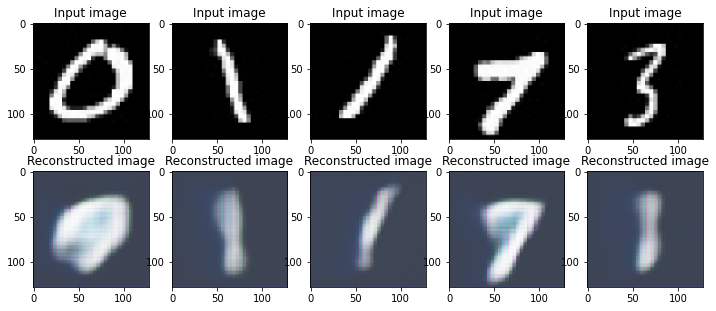

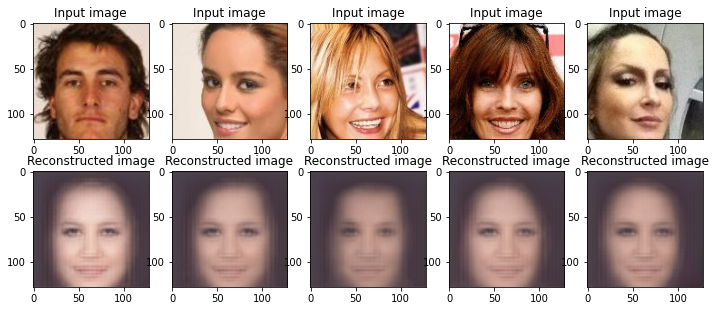

In [36]:
figure, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.ravel()
for i,data in enumerate(torch_validation_mnist):
    if(i > 4):
        break
    data = data.to(device)
    output, mu, std = mnist_autoencoder(data)
    axes[i].imshow(data.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[i].set_title("Input image")
    axes[i+5].imshow(output.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[i+5].set_title("Reconstructed image")

figure, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.ravel()
for i,data in enumerate(torch_validation_celeba):
    if(i > 4):
        break
    data = data.to(device)
    output, mu, std = celeba_autoencoder(data)

    axes[i].imshow(data.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[i].set_title("Input image")
    axes[i+5].imshow(output.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    axes[i+5].set_title("Reconstructed image")

plt.show()

The definition of the perceptual loss function is critical to the performance of the generative model. Mean Square Error loss function is used in VGG model to compare 2 similar images and take per-pixel difference.

```
# VGG Perceptual Loss Class
loss = nn.MSELoss()
vgg_perceptual_loss = 2e-3 * (loss(x1, y1) + loss(x2, y2))

# In training loop
output, mu, std = mnist_autoencoder(data)
loss = vgg_perceptual_loss(output, data) + 0.1 * kl_divergence_loss(mu,std)
```

After many trials and errors, I found the weighting of each VGG layer to be $\alpha$ = 0.002. I also find the loss function combined with KL-Divergence loss function to be somewhat effective in generating usable new samples. My reason to use small weighting for VGG layers is that the point is not to reconstruct a perfectly original image at the output but instead to generate new samples, so the loss function in VGG should be less critical. And in the training loop, the KL-Divergence loss function is used in combination with VGG as the KL-Divergence loss function makes the VAE learn the data associated with probability distribution (Gaussian) and learn parameters of the distribution.

\begin{equation}
  \Sigma^n_{i = 0} \alpha_i || vgg_i(I) − vgg_i(dec(enc(I))) ||^2_2
\end{equation}

For the generation of new samples (figure above), we can see the reconstructed image is quite different from the original input image. We can observe that the output images are often similar in details or features for celebA.